# The model of Blood_Cell prediction

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import keras
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

path_to_train = os.path.join('dataset2-master', 'images', 'TRAIN')
print(path_to_train)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN


In [2]:
tf.__version__

'2.12.0'

In [3]:
keras.__version__

'2.12.0'

In [4]:
cell_type = os.path.join(path_to_train, 'EOSINOPHIL')
for image_path in os.listdir(cell_type):
    print(image_path)
    break 

_13_5603.jpeg


## Creating of two datasets: X (images) and (y) labels 

In [5]:
cell_types = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

path_to_images = os.path.join('/kaggle','input','blood-cells', 'dataset2-master', 'dataset2-master', 'images')

X, y = [], []

path = os.path.join(path_to_images, 'TEST')
for cell_type in cell_types:
    cell_type_path = os.path.join(path, cell_type)
    list_of_images = os.listdir(cell_type_path)
    for image in list_of_images[:len(list_of_images)]:
        if image.endswith('.jpeg'):
            image_path = os.path.join(cell_type_path, image)
            im = np.array(Image.open(image_path))
            X.append(im)
            y.append(cell_type)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y)

## Reshaping X_test and X_train datasets images to shape appropriate to ResNet model

In [7]:
X_train_reshaped = []
X_test_reshaped = []
for i in np.array(X_train):
    ir = cv2.resize(i, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    X_train_reshaped.append(ir)
for i in np.array(X_test):
    ir = cv2.resize(i, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    X_test_reshaped.append(ir)
X_train = np.stack(X_train_reshaped).astype('float16')/255
X_test = np.stack(X_test_reshaped).astype('float16')/255

In [8]:
X_train.shape

(1989, 224, 224, 3)

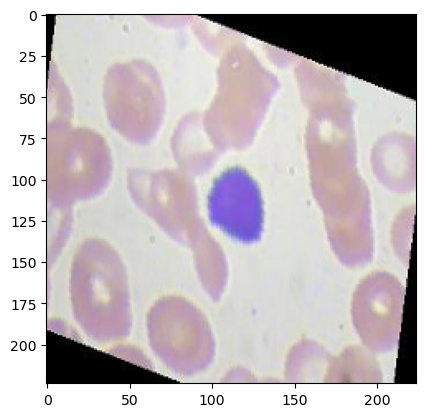

In [10]:
plt.imshow(X_train_reshaped[1])

## Endcoding the labels

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

label_encoder = LabelEncoder()

label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [12]:
y_test[234]

array([1., 0., 0., 0.], dtype=float32)

## Creating and compiling ResNet50V2 model

In [16]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import Adam 

model_res = ResNet50V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=4,
    classifier_activation='softmax'
)
model_res.compile(optimizer = Adam() , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

## Training the model

In [17]:
model_res.fit(X_train, y_train, batch_size=100, epochs=65, validation_data=(X_test, y_test))

Epoch 1/65
20/20 [==============================] - 40s 551ms/step - loss: 0.9744 - accuracy: 0.5897 - val_loss: 2.5185 - val_accuracy: 0.2510
Epoch 2/65
20/20 [==============================] - 9s 462ms/step - loss: 0.2222 - accuracy: 0.9226 - val_loss: 3.4745 - val_accuracy: 0.2510
Epoch 3/65
20/20 [==============================] - 9s 463ms/step - loss: 0.2059 - accuracy: 0.9221 - val_loss: 9.2859 - val_accuracy: 0.2510
Epoch 4/65
20/20 [==============================] - 9s 463ms/step - loss: 0.0606 - accuracy: 0.9794 - val_loss: 3.2780 - val_accuracy: 0.2510
Epoch 5/65
20/20 [==============================] - 9s 464ms/step - loss: 0.0833 - accuracy: 0.9754 - val_loss: 10.6785 - val_accuracy: 0.2490
Epoch 6/65
20/20 [==============================] - 9s 465ms/step - loss: 0.1094 - accuracy: 0.9583 - val_loss: 30.8570 - val_accuracy: 0.3956
Epoch 7/65
20/20 [==============================] - 9s 466ms/step - loss: 0.0391 - accuracy: 0.9884 - val_loss: 48.1367 - val_accuracy: 0.3313
Ep

**The validation accuracy is 99.6%**

## Re-cheking the accuracy by selecting a random image 

In [18]:
def predict_cell_type(im_path, model, label_encoder):
    im_arr = np.array(Image.open(im_path))
    resized = cv2.resize(im_arr, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    norm = resized.astype('float16')/255
    ex_im = np.expand_dims(norm, axis=0)
    pred = model.predict(ex_im)
    mp = pred.argmax()
    cl = label_encoder.classes_
    return cl[mp]

In [19]:
path_to_images = os.path.join('/kaggle','input','blood-cells', 'dataset2-master', 'dataset2-master', 'images', 'TEST_SIMPLE')
list_of_types = os.listdir(path_to_images)
path_to_images

'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE'

In [20]:
predict_cell_type('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/MONOCYTE/_3_9457.jpeg',
                  model_res, label_encoder)

1/1 [==============================] - 1s 1s/step


'MONOCYTE'

## Saving the model as .json and weights as .h5

In [22]:
model_json = model_res.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model_res.save_weights("model_weights.h5")